In [ ]:
import keras
import cv2
from skimage.transform import rotate, resize, SimilarityTransform, warp
import os
import numpy as np
import pickle
import random as rand
import matplotlib.pyplot as plt
import copy
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.callbacks import ModelCheckpoint
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
INPUT_SHAPE = (96, 96, 3)
IM_HEIGHT = 96
IM_WIDTH = 96
OUTPUT_SIZE = 2

LEARNING_RATE = 0.0005
OPTIMIZER = keras.optimizers.Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRIC = 'accuracy'

SL_TRAIN_SIZE = 40411
SL_VALIDATION_SIZE = 9668
SL_TEST_SIZE = 13539
EPOCHS = 25
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 50
STEPS_PER_EPOCH = (2 * SL_TRAIN_SIZE) // BATCH_SIZE + 1
VALIDATION_STEPS_PER_EPOCH = (2 * SL_VALIDATION_SIZE) // BATCH_SIZE + 1
MAX_EPOCHS_WITH_SAME_DATA_SET = 5

TRAIN_PATH = "./data_set/train/"
VALIDATION_PATH = "./data_set/validation/"
TEST_PATH = "./data_set/test/"

MODEL_PATH = "./binary_classifier/net_2_model.h5"

MR_CKPT_PATH = "./binary_classifier/net_2_most_recent_checkpoint.hdf5"
CB_CKPT_PATH = "./binary_classifier/net_2_current_best_checkpoint.hdf5"

In [3]:
def transform_image(img):
    sel = [0, 1]
    offset = 72
    bound = (72 - 48) / 2
    t_img = np.array(img)
    
    # Rotate
    angle = rand.uniform(0, 360)
    t_img = rotate(t_img, angle, mode='edge')
    
    # Flip
    if rand.choice(sel):
        t_img = np.flipud(t_img)
    if rand.choice(sel):
        t_img = np.fliplr(t_img)
    
    # Shift
    tform = SimilarityTransform(translation=(int(rand.uniform(-bound, bound)), int(rand.uniform(-bound, bound))))
    t_img = warp(t_img, tform)
    
    # Zoom and cut 96x96 patch
    zoom = int(rand.uniform(-bound, bound))
    t_img = resize(t_img[offset-48-zoom:offset+48+zoom, offset-48-zoom:offset+48+zoom, :], (96, 96))
    return t_img.tolist()

In [4]:
def train_generator():
    sl_lst_tmp = os.listdir(TRAIN_PATH + '0_sea_lions')
    sl_lst = []
    for elem in sl_lst_tmp:
        sl_lst.append(list((cv2.imread(TRAIN_PATH + '0_sea_lions/' + elem), 'sea_lion')))
    bkg_lst_tmp = os.listdir(TRAIN_PATH + '1_background')
    for k in range(EPOCHS // MAX_EPOCHS_WITH_SAME_DATA_SET):
        img_lst = []
        for elem in rand.sample(bkg_lst_tmp, SL_TRAIN_SIZE):
            img_lst.append(list((cv2.imread(TRAIN_PATH + '1_background/' + elem), 'background')))
        img_lst = sl_lst + img_lst
        rand.shuffle(img_lst)
        for i in range(MAX_EPOCHS_WITH_SAME_DATA_SET):
            patches = []
            classes = []
            curr_batch_size = 0
            for elem in img_lst:
                if elem[1] == 'background':
                    patches.append(elem[0])
                    classes.append([0, 1])
                else:
                    patches.append(transform_image(elem[0]))
                    classes.append([1, 0])
                curr_batch_size += 1
                if curr_batch_size == BATCH_SIZE:
                    X_train = np.array(patches)
                    X_train = X_train.astype('float32')
                    X_train /= 255
                    Y_train = np.array(classes)
                    curr_batch_size = 0
                    patches = []
                    classes = []
                    yield X_train, Y_train
            if len(patches) > 0:
                X_train = np.array(patches)
                X_train = X_train.astype('float32')
                X_train /= 255
                Y_train = np.array(classes)
                yield X_train, Y_train

In [5]:
# Validation data set
X_validation = []
Y_validation = []
validation_set = []
lst = os.listdir(VALIDATION_PATH + '0_sea_lions')
for elem in lst:
    validation_set.append(list((cv2.imread(VALIDATION_PATH + '0_sea_lions/' + elem), 'sea_lion')))
lst = os.listdir(VALIDATION_PATH + '1_background')
for elem in lst:
    validation_set.append(list((cv2.imread(VALIDATION_PATH + '1_background/' + elem), 'background')))
rand.shuffle(validation_set)
for data in validation_set:
    X_validation.append(data[0])
    if data[1] == 'sea_lion':
        Y_validation.append([1, 0])
    else:
        Y_validation.append([0, 1])

X_validation = np.array(X_validation, copy=False)
# Convert data types and normalize values
X_validation = X_validation.astype('float32')
X_validation /= 255
Y_validation = np.array(Y_validation, copy=False)

# Free memory
lst = []
validation_set = []

In [6]:
class History(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.accuracies = []
        self.val_acc = []
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, batch, logs={}):
        self.accuracies.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

    
history = History()

In [ ]:
# Build model

model = Sequential()
# First layer
model.add(Convolution2D(8, (5, 5), activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth layer
model.add(Convolution2D(10, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(OUTPUT_SIZE, activation='softmax'))

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])

In [7]:
# Checkpointers

# most recent checkpoint
mr_checkpointer = ModelCheckpoint(filepath=MR_CKPT_PATH, verbose=1, save_best_only=False)
# current best checkpoint
cb_checkpointer = ModelCheckpoint(filepath=CB_CKPT_PATH, verbose=1, save_best_only=True)



In [8]:
# Train

# Fit model on training data
history = model.fit_generator(
    train_generator(),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_validation, Y_validation),
    validation_steps=VALIDATION_STEPS_PER_EPOCH,
    workers=8,
    max_queue_size=50,
    callbacks=[mr_checkpointer, cb_checkpointer, history])


Epoch 1/25


/home/marco/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1617/1617 [==============================] - 1075s 665ms/step - loss: 0.0229 - acc: 0.9983 - val_loss: 7.6511 - val_acc: 0.5227

Epoch 00001: saving model to ./binary_classifier/net_2_most_recent_checkpoint.hdf5

Epoch 00001: val_loss improved from inf to 7.65110, saving model to ./binary_classifier/net_2_current_best_checkpoint.hdf5
Epoch 2/25
1617/1617 [==============================] - 698s 432ms/step - loss: 6.4574e-06 - acc: 1.0000 - val_loss: 7.6511 - val_acc: 0.5227

Epoch 00002: saving model to ./binary_classifier/net_2_most_recent_checkpoint.hdf5

Epoch 00002: val_loss improved from 7.65110 to 7.65109, saving model to ./binary_classifier/net_2_current_best_checkpoint.hdf5
Epoch 3/25
1617/1617 [==============================] - 705s 436ms/step - loss: 1.5881e-06 - acc: 1.0000 - val_loss: 7.6511 - val_acc: 0.5227

Epoch 00003: saving model to ./binary_classifier/net_2_most_recent_checkpoint.hdf5

Epoch 00003: val_loss improved from 7.65109 to 7.65109, saving model to ./binary_cl

In [ ]:
#Save history 
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

save_object(history, 'history.pkl')

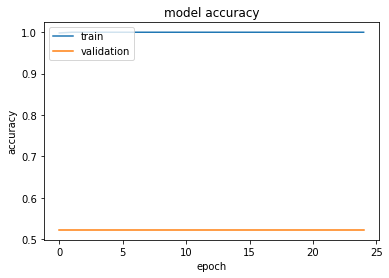

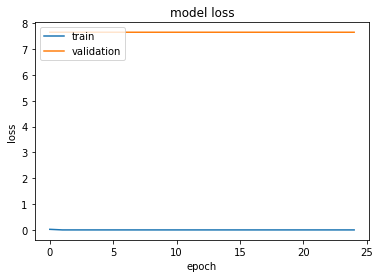

In [9]:
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
# Save trained model

# serialize model to HDF5
model.save(MODEL_PATH)